In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import arviz as az
import tensorflow_probability as tfp
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd

from zoobot.active_learning import acquisition_utils
from zoobot.active_learning.metrics import IterationState
from zoobot import label_metadata
from zoobot.estimators import losses, dirichlet_stats

In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


## Check hpd works

In [5]:
import scipy.stats

11 19
0.9012628532946048


(0, 30)

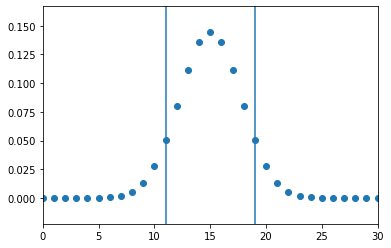

In [6]:
n = 30
k = np.arange(0, n+1)
p = 0.5
posterior = scipy.stats.binom.pmf(k, n, p)

(lower_lim, upper_lim), confidence = dirichlet_stats.get_hpd(k, posterior, ci=.8)
print(lower_lim, upper_lim)
print(confidence)

plt.scatter(k, posterior)
plt.axvline(lower_lim)
plt.axvline(upper_lim)
plt.xlim(0, n)

In [7]:
posterior[lower_lim:upper_lim+1].sum()

0.9012628532946048

In [8]:
posterior[lower_lim:upper_lim].sum()

0.850387215614313

## Use predictions

In [10]:

# state_loc = 'results/4q/latest_dirichlet_unfiltered_active_m3_warm/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_partial_label_cols
# questions = label_metadata.gz2_partial_questions



# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions
# version = 'gz2'
# schema = losses.Schema(label_cols, questions, version=version)

# with open(state_loc, 'rb') as f:
#     state = pickle.load(f)

# samples_list = state.samples
# n_models = len(state.samples)
# state.samples[0].shape, state.acquisitions.shape, len(state.id_strs)

# catalog_loc = 'data/gz2/gz2_master_catalog.csv'
# catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
# catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))


from zoobot.estimators import concentration_utils

label_cols = label_metadata.decals_label_cols
questions = label_metadata.decals_questions
version = 'decals'
schema = losses.Schema(label_cols, questions, version=version)

predictions_loc = 'results/temp/decals_n2_allq_m0_all.csv'
predictions = pd.read_csv(predictions_loc)
# filter to eval
eval_loc = 'results/temp/decals_n2_allq_m0_eval_shards/eval_df.csv'
eval_df = pd.read_csv(eval_loc)
eval_predictions = predictions[predictions['iauname'].isin(eval_df['id_str'])]
print(len(eval_predictions))
samples = concentration_utils.load_all_concentrations(eval_predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
samples_list = [samples]

catalog = eval_predictions


# batch_size = 8
# initial_size = 300
# # initial_size = 128
# crop_size = int(initial_size * 0.75)
# # crop_size = 128
# final_size = 224
# channels = 3



{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}
10000


In [11]:
samples.shape

(10000, 34, 5)

In [36]:
schema.questions

[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [ ]:
# binary_questions = [
#     schema.get_question('disk-edge-on'),
#     schema.get_question('has-spiral-arms')

In [12]:
n_samples = samples_list[0].shape[2]

In [113]:
# question = schema.get_question('smooth-or-featured')  # not binary any more!
question = schema.get_question('has-spiral-arms')
# question = schema.get_question('disk-edge-on')
# question = schema.get_question('bar')
answer = question.answers[0]
answer.text

'has-spiral-arms_yes'

In [114]:
# all_galaxy_posteriors = dirichlet_stats.get_posteriors(samples_list[0][:1000], catalog, state.id_strs, question, answer)
all_galaxy_posteriors = dirichlet_stats.get_posteriors(samples_list[0][:1000], catalog, list(catalog['iauname']), question, answer)

1.0000052
0.9999927
0.9999993
1.0000086
1.0000079


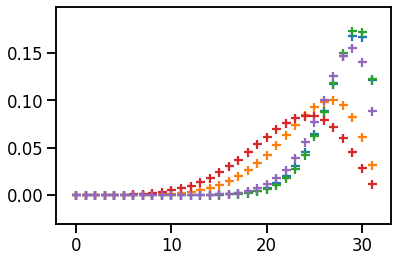

In [115]:
x, p = all_galaxy_posteriors[0]
for d in p:
    print(d.sum())
    plt.scatter(x, d, marker='+')

1.000002
0.9999979
1.0000052
1.0000013
1.0000027


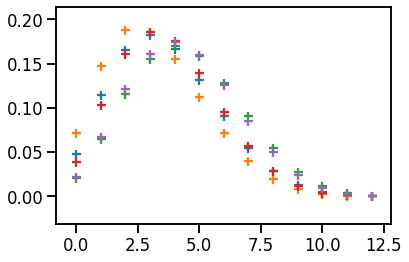

In [116]:
x, p = all_galaxy_posteriors[1]
for d in p:
    print(d.sum())
    plt.scatter(x, d, marker='+')

In [117]:
(lower_edge, upper_edge), confidence = dirichlet_stats.get_hpd(x, d, ci=.9)

In [118]:
lower_edge, upper_edge, confidence

(0.0, 8.0, 0.9639844)

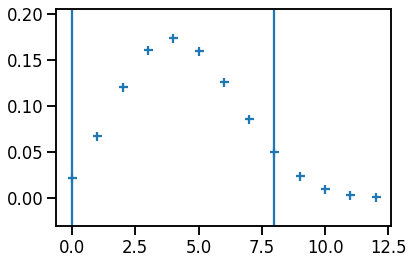

In [119]:
plt.scatter(x, d, marker='+')
plt.axvline(lower_edge)
plt.axvline(upper_edge)

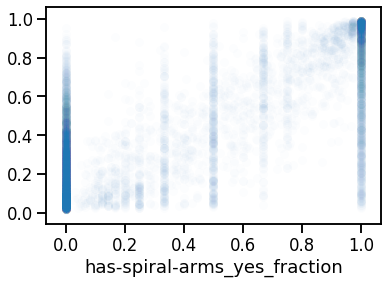

In [120]:
sns.scatterplot(x=eval_predictions['has-spiral-arms_yes_fraction'], y=eval_predictions['has-spiral-arms_yes_concentration_mean']/(eval_predictions['has-spiral-arms_no_concentration_mean'] + eval_predictions['has-spiral-arms_yes_concentration_mean']), alpha=.01)

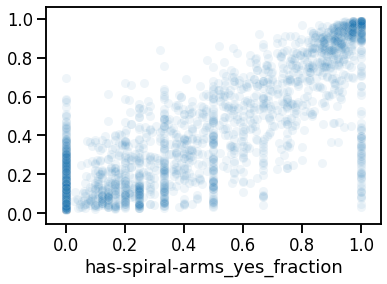

In [121]:
is_retired = eval_predictions['smooth-or-featured_total-votes'] > 36 
retired = eval_predictions[is_retired]
sns.scatterplot(x=retired['has-spiral-arms_yes_fraction'], y=retired['has-spiral-arms_yes_concentration_mean']/(retired['has-spiral-arms_no_concentration_mean'] + retired['has-spiral-arms_yes_concentration_mean']), alpha=.07)

In [122]:
is_retired.values

array([ True,  True,  True, ..., False, False, False])

In [123]:
n_galaxies = 1000

# id_strs = list(retired['iauname'])
# samples_list = [samples[is_retired.values]]

id_strs = list(catalog['iauname'])
samples_list = [samples]

all_samples = np.concatenate(samples_list, axis=2)
# all_galaxy_posteriors = dirichlet_stats.get_posteriors(all_samples[:n_galaxies], catalog, state.id_strs, question, answer)  
all_galaxy_posteriors = dirichlet_stats.get_posteriors(all_samples[:n_galaxies], catalog, id_strs, question, answer)  
first_posteriors = [(x, p[0]) for x, p in all_galaxy_posteriors]
mean_posteriors = [(x, p.mean(axis=0)) for x, p in all_galaxy_posteriors]
true_values = dirichlet_stats.get_true_values(catalog, list(catalog['iauname']), answer)

coverage_first = dirichlet_stats.get_coverage(first_posteriors, true_values)
coverage_all = dirichlet_stats.get_coverage(mean_posteriors, true_values)

In [124]:
# measure true_within_hpd, binned by confidence
n_bins = 10
coverage_first['confidence_bin'], bins = pd.cut(coverage_first['confidence'], bins=n_bins, retbins=True)
coverage_first['bin_center'] = coverage_first['confidence_bin'].apply(lambda interval: interval.mid)

# measure true_within_hpd, binned by confidence
coverage_all['confidence_bin'], bins = pd.cut(coverage_all['confidence'], bins=n_bins, retbins=True)
coverage_all['bin_center'] = coverage_all['confidence_bin'].apply(lambda interval: interval.mid)

In [125]:
from matplotlib.ticker import PercentFormatter

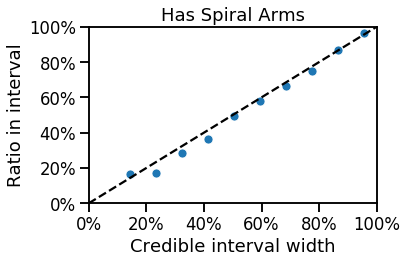

In [126]:
sns.set_context('talk')
fig, ax = plt.subplots()
grouped_by_bin = coverage_first.groupby('bin_center').agg({'true_within_hpd': 'mean'}).reset_index()
sns.scatterplot(data=grouped_by_bin, x='bin_center', y='true_within_hpd')
ax.plot([0., 1.], [0., 1.], 'k--')
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.)
ax.set_ylabel('Ratio in interval')
ax.set_xlabel('Credible interval width')
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.))
ax.set_title(question.text.replace('-', ' ').title())
fig.tight_layout()
fig.savefig('calibration_single_model_' + question.text + '.pdf')

Text(0.5, 1.0, 'disk-edge-on')

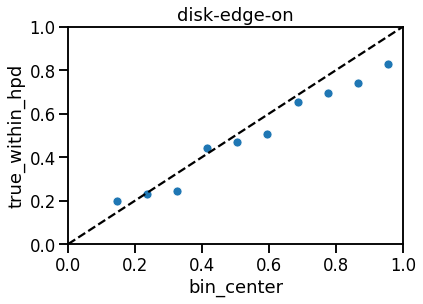

In [102]:
grouped_by_bin = coverage_all.groupby('bin_center').agg({'true_within_hpd': 'mean'}).reset_index()
sns.scatterplot(data=grouped_by_bin, x='bin_center', y='true_within_hpd')
plt.plot([0., 1.], [0., 1.], 'k--')
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.title(question.text)

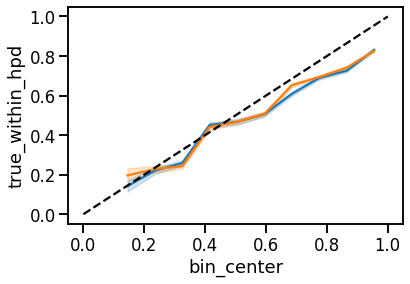

In [103]:
sns.lineplot(data=coverage_first, x='bin_center', y='true_within_hpd', ci=90)
sns.lineplot(data=coverage_all, x='bin_center', y='true_within_hpd', ci=90)
plt.plot([0., 1.], [0., 1.], 'k--')

In [104]:
coverage_first.groupby('confidence_bin').agg({'true_within_hpd': 'mean'})

,true_within_hpd
confidence_bin,
"(0.0996, 0.19]",0.142132
"(0.19, 0.28]",0.219963
"(0.28, 0.37]",0.258828
"(0.37, 0.46]",0.451434
"(0.46, 0.55]",0.466632
"(0.55, 0.64]",0.505640
"(0.64, 0.73]",0.608789
"(0.73, 0.82]",0.689604
"(0.82, 0.91]",0.725595


(0.0, 1.0)

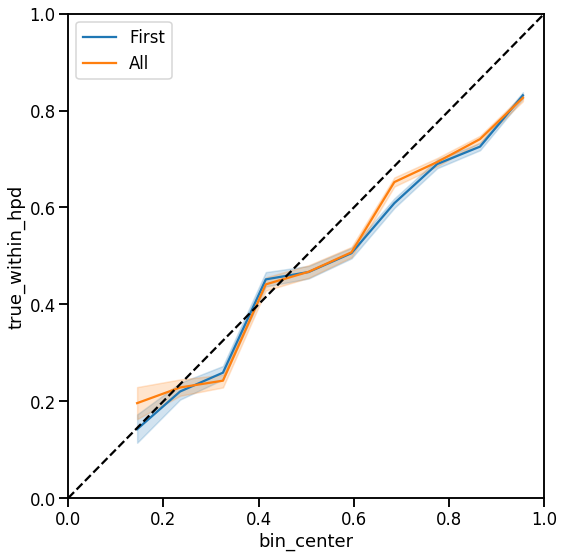

In [105]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=coverage_first, x='bin_center', y='true_within_hpd', ax=ax, ci=90, label='First')
sns.lineplot(data=coverage_all, x='bin_center', y='true_within_hpd', ax=ax, ci=90, label='All')
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

In [106]:
top_acq = np.argsort(state.acquisitions) > (4 * len(state.acquisitions) / 5.)
print(top_acq.mean())

selector = top_acq
coverage_first = dirichlet_stats.get_coverage(
    [y for n, y in enumerate(first_posteriors) if selector[n]],
    [y for n, y in enumerate(true_values) if selector[n]]
)
coverage_all = dirichlet_stats.get_coverage(
    [y for n, y in enumerate(mean_posteriors) if selector[n]],
    [y for n, y in enumerate(true_values) if selector[n]]
)

fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=coverage_first, x='ci_width', y='true_within_hpd', ax=ax, ci=90, label='First')
sns.lineplot(data=coverage_all, x='ci_width', y='true_within_hpd', ax=ax, ci=90, label='All')
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

NameError: name 'state' is not defined